
# Insomnia ML Lab — Public Edition

**Created by DBbun LLC. © DBbun LLC. Commercial use requires a license.**  
For licensing inquiries, contact DBbun LLC.

---

### What is *EDA*?
**Exploratory Data Analysis (EDA)** is the first-pass exploration of a dataset — looking at shapes, missing values, descriptive statistics, and simple plots — to understand data quality, ranges, and potential issues before modeling.

### What does *tidy* mean?
**Tidy data** (a term popularized by the data science community) means:
- each **row** is one observation (e.g., one patient),
- each **column** is one variable (e.g., age, BMI),
- each **table** contains one kind of thing.
We export a *tidy metrics CSV* so each row is a model and each column is a metric (AUC, F1, etc.).

> This notebook uses a **practice-ready synthetic dataset** intended for education and reproducible method demos.



## What you'll do
- Load a **synthetic insomnia cohort** (or auto-generate one locally if no CSV is present)
- Explore the data and its **realistic variability** (missing values, measurement variation)
- Build pipelines with **imputation, encoding, and scaling**
- Train **Logistic Regression**, **Random Forest**, **Gradient Boosting** (plus a **Dummy** baseline)
- Evaluate with **ROC-AUC, PR-AUC, Accuracy, F1, Brier score**, and **5-fold CV AUC**
- Visualize **ROC**, **PR**, and **Calibration** curves
- **Tune the decision threshold** for best F1 and inspect **confusion matrices**

> **License notice:** This notebook and any datasets it generates are © DBbun LLC. Any **commercial use requires a license** from DBbun LLC.


In [6]:

import os
import math
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    brier_score_loss, roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 7

# Preferred input files created by your generator
PRIMARY = Path("patients_100k.csv")  # typical output from the generator
FALLBACK = Path("patients_demo.csv") # optional demo if present


## Load data (or generate a **practice-ready** synthetic dataset)

In [7]:

def generate_practice_dataset(n=4000, seed=7):
    rng = np.random.default_rng(seed)
    # Demographics
    age = np.clip(rng.normal(62.0, 16.3, n), 18, None)
    female = rng.binomial(1, 0.594, n)
    bmi = np.clip(rng.normal(30.0, 8.2, n), 10, None)
    ethnicity = rng.choice(["Caucasian","African American","Hispanic","Asian","Other","Unknown"],
                           size=n, p=[0.729,0.104,0.108,0.020,0.011,0.028])
    smoking = rng.choice(["Current","Past","Never","Unknown"], size=n, p=[0.169,0.237,0.503,0.091])

    # Comorbidities
    def b(p): return rng.binomial(1, p, n)
    comorb = {
        "hypertension": b(0.754), "lipid_metabolism_disorder": b(0.665), "diabetes": b(0.559),
        "gastrointestinal_disorder": b(0.530), "anxiety_or_depression": b(0.469),
        "psychiatric_disorder": b(0.384), "pneumonia": b(0.371), "obesity": b(0.342),
        "congestive_heart_failure": b(0.327), "coronary_artery_disease": b(0.279),
        "asthma": b(0.239), "copd": b(0.235), "cerebrovascular_disease": b(0.229),
        "afib_or_flutter": b(0.218), "cancer": b(0.218), "peripheral_vascular_disease": b(0.197),
        "osteoporosis": b(0.181), "ckd_or_esrd": b(0.163), "renal_failure": b(0.123)
    }

    # Utilization/count features
    def pois(lam): return rng.poisson(lam, n)
    sleep_notes = pois(0.5)
    insomnia_codes = pois(0.2)
    anxdep_codes = pois(0.6)
    psych_notes = pois(0.3)
    insomnia_rx = pois(0.3)
    joint_codes = pois(0.4)
    emr_facts = np.clip(rng.normal(500.0, 200.0, n), 0, None)

    df = pd.DataFrame({
        "age": np.round(age,1),
        "sex": np.where(female==1,"Female","Male"),
        "bmi": np.round(bmi,1),
        "ethnicity": ethnicity,
        "smoking_status": smoking,
        "sleep_disorder_note_count": sleep_notes,
        "insomnia_billing_code_count": insomnia_codes,
        "anx_depr_billing_code_count": anxdep_codes,
        "psych_note_count": psych_notes,
        "insomnia_rx_count": insomnia_rx,
        "joint_disorder_billing_code_count": joint_codes,
        "emr_fact_count": emr_facts.astype(int),
        **comorb
    })

    # Realistic measurement variation
    lognormal_noise = np.exp(rng.normal(0, 0.15, n))
    for c in ["sleep_disorder_note_count","insomnia_billing_code_count","anx_depr_billing_code_count",
              "psych_note_count","insomnia_rx_count","joint_disorder_billing_code_count"]:
        df[c] = np.clip(np.round(df[c].values * lognormal_noise).astype(int), 0, None)
    for c in ["bmi","emr_fact_count"]:
        sd = df[c].std(ddof=1)
        df[c] = df[c] + rng.normal(0, 0.15*sd, n)

    # A few outliers
    k = int(0.01*n)
    if k>0:
        idx = rng.choice(n, size=k, replace=False)
        df.loc[idx, "emr_fact_count"] = np.clip(np.round(df.loc[idx, "emr_fact_count"] * rng.uniform(3,10, size=k)).astype(int),0,None)

    # Missing values (MCAR + mild age-dependent patterns)
    miss_cols = ["bmi","smoking_status","ethnicity","emr_fact_count"]
    for c in miss_cols:
        m = rng.random(n) < 0.03
        df.loc[m, c] = np.nan
    z = (df["age"] - df["age"].mean())/(df["age"].std(ddof=1)+1e-9)
    p_mar = (0.07 * (0.5 + 0.5 * (z - z.min())/(z.max()-z.min()+1e-9))).clip(0, 0.5)
    for c in miss_cols:
        m = rng.random(n) < p_mar
        df.loc[m, c] = np.nan

    # Probabilistic label using available features + latent variation
    B = dict(
        intercept=-1.927027677,
        sleep=2.329738590, ins=0.802462562, anx=0.264231683, psych=0.098835169,
        rx=0.086364249, joint=0.048271004, emr=0.000231521
    )
    L = (B["intercept"] + B["sleep"]*df["sleep_disorder_note_count"].fillna(0) +
         B["ins"]*df["insomnia_billing_code_count"].fillna(0) +
         B["anx"]*df["anx_depr_billing_code_count"].fillna(0) +
         B["psych"]*df["psych_note_count"].fillna(0) +
         B["rx"]*df["insomnia_rx_count"].fillna(0) +
         B["joint"]*df["joint_disorder_billing_code_count"].fillna(0) +
         B["emr"]*df["emr_fact_count"].fillna(0))
    p = 1/(1+np.exp(-L))
    p = np.clip(p, 1e-6, 1-1e-6)
    logit = np.log(p/(1-p))
    eps = rng.normal(0, 0.35, n)                 # latent variation
    p_star = 1/(1+np.exp(-(logit + eps)))
    y = (rng.random(n) < p_star).astype(int)
    flips = rng.choice(n, int(0.03*n), replace=False)  # small residual uncertainty
    y[flips] = 1 - y[flips]
    df["insomnia_probability"] = p_star
    df["insomnia_class"] = y
    return df

# Load priority: patients_100k.csv > patients_10k.csv > generated dataset
if PRIMARY.exists():
    df = pd.read_csv(PRIMARY)
    print(f"Loaded {len(df)} rows from {PRIMARY}")
elif FALLBACK.exists():
    df = pd.read_csv(FALLBACK)
    print(f"Loaded {len(df)} rows from {FALLBACK}")
else:
    df = generate_practice_dataset(n=4000, seed=RANDOM_STATE)
    print("No input CSV found — generated a practice-ready synthetic dataset in memory.")

df.head()


No input CSV found — generated a practice-ready synthetic dataset in memory.


,age,sex,bmi,ethnicity,smoking_status,sleep_disorder_note_count,insomnia_billing_code_count,anx_depr_billing_code_count,psych_note_count,insomnia_rx_count,joint_disorder_billing_code_count,emr_fact_count,hypertension,lipid_metabolism_disorder,diabetes,gastrointestinal_disorder,anxiety_or_depression,psychiatric_disorder,pneumonia,obesity,congestive_heart_failure,coronary_artery_disease,asthma,copd,cerebrovascular_disease,afib_or_flutter,cancer,peripheral_vascular_disease,osteoporosis,ckd_or_esrd,renal_failure,insomnia_probability,insomnia_class
0,62.0,Female,32.333483,Caucasian,Past,1,0,1,0,0,2,85.963744,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0.686818,0
1,66.9,Female,20.745808,Caucasian,Never,0,0,1,1,0,1,986.967833,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.209485,0
2,57.5,Male,30.894698,African American,Current,0,0,0,1,1,1,860.446694,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.157883,1
3,47.5,Female,27.941499,Hispanic,Never,0,1,2,1,0,0,553.725574,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.376774,1
4,54.6,Female,28.349807,Caucasian,Never,1,0,2,1,0,0,636.335891,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0.771102,1


## Explore the data (EDA)

In [8]:

print("Shape:", df.shape)
print("Target prevalence:", float(df["insomnia_class"].mean()).__round__(4))

# Missingness per column
missing_rate = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 15):")
display(missing_rate.head(15))

# Numeric summary (selected)
display(df.select_dtypes(include=[np.number]).describe().T.head(15))


Shape: (4000, 33)
Target prevalence: 0.424

Missingness (top 15):


smoking_status                       0.08525
emr_fact_count                       0.08375
bmi                                  0.07650
ethnicity                            0.07600
age                                  0.00000
sleep_disorder_note_count            0.00000
insomnia_billing_code_count          0.00000
anx_depr_billing_code_count          0.00000
sex                                  0.00000
psych_note_count                     0.00000
insomnia_rx_count                    0.00000
joint_disorder_billing_code_count    0.00000
hypertension                         0.00000
lipid_metabolism_disorder            0.00000
diabetes                             0.00000
dtype: float64

,count,mean,std,min,25%,50%,75%,max
age,4000.0,61.725175,16.124458,18.000000,50.600000,61.400000,72.700000,114.100000
bmi,3694.0,30.062841,8.311627,7.432547,24.696359,30.017226,35.849604,60.536736
sleep_disorder_note_count,4000.0,0.501500,0.723622,0.000000,0.000000,0.000000,1.000000,5.000000
insomnia_billing_code_count,4000.0,0.188500,0.426630,0.000000,0.000000,0.000000,0.000000,3.000000
anx_depr_billing_code_count,4000.0,0.611000,0.804886,0.000000,0.000000,0.000000,1.000000,6.000000
psych_note_count,4000.0,0.297250,0.545405,0.000000,0.000000,0.000000,1.000000,4.000000
insomnia_rx_count,4000.0,0.293750,0.544091,0.000000,0.000000,0.000000,1.000000,3.000000
joint_disorder_billing_code_count,4000.0,0.404750,0.646167,0.000000,0.000000,0.000000,1.000000,5.000000
emr_fact_count,3665.0,528.377369,390.550785,-52.307192,362.898095,503.206502,641.347476,7573.000000
hypertension,4000.0,0.741750,0.437727,0.000000,0.000000,1.000000,1.000000,1.000000


## Train / Test split and preprocessing

In [9]:

TARGET = "insomnia_class"
assert TARGET in df.columns, "insomnia_class column missing."

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((3000, 32), (1000, 32))

## Train models and evaluate (hold-out)

In [10]:

results = {}

def eval_and_store(name, y_true, y_prob, y_pred):
    results[name] = dict(
        roc_auc = roc_auc_score(y_true, y_prob),
        pr_auc  = average_precision_score(y_true, y_prob),
        acc     = accuracy_score(y_true, y_pred),
        f1      = f1_score(y_true, y_pred),
        brier   = brier_score_loss(y_true, y_prob),
    )

# 1) Dummy baseline
pipe_dummy = Pipeline([("prep", preprocess),
                       ("clf", DummyClassifier(strategy="stratified", random_state=RANDOM_STATE))])
pipe_dummy.fit(X_train, y_train)
p_dum = pipe_dummy.predict_proba(X_test)[:,1]
yhat_dum = pipe_dummy.predict(X_test)
eval_and_store("Dummy", y_test, p_dum, yhat_dum)

# 2) Logistic Regression
pipe_lr = Pipeline([("prep", preprocess),
                    ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))])
pipe_lr.fit(X_train, y_train)
p_lr = pipe_lr.predict_proba(X_test)[:,1]
yhat_lr = (p_lr >= 0.5).astype(int)
eval_and_store("LogisticRegression", y_test, p_lr, yhat_lr)

# 3) Random Forest
pipe_rf = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
p_rf = pipe_rf.predict_proba(X_test)[:,1]
yhat_rf = (p_rf >= 0.5).astype(int)
eval_and_store("RandomForest", y_test, p_rf, yhat_rf)

# 4) Gradient Boosting
pipe_gb = Pipeline([("prep", preprocess),
                    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))])
pipe_gb.fit(X_train, y_train)
p_gb = pipe_gb.predict_proba(X_test)[:,1]
yhat_gb = (p_gb >= 0.5).astype(int)
eval_and_store("GradientBoosting", y_test, p_gb, yhat_gb)

pd.DataFrame(results).T.round(4)


,roc_auc,pr_auc,acc,f1,brier
Dummy,0.4913,0.4198,0.505,0.4072,0.4950
LogisticRegression,0.7978,0.7657,0.761,0.7031,0.1745
RandomForest,0.8041,0.7722,0.761,0.6963,0.1733
GradientBoosting,0.7994,0.7701,0.756,0.6856,0.1746


## Cross-validated ROC-AUC (Stratified 5-fold)

In [11]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = {}
for name, pipe in [
    ("LogisticRegression", pipe_lr),
    ("RandomForest", pipe_rf),
    ("GradientBoosting", pipe_gb),
]:
    aucs = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=None)
    cv_scores[name] = dict(mean=float(aucs.mean()), std=float(aucs.std()))
pd.DataFrame(cv_scores).T.round(4)


,mean,std
LogisticRegression,0.8057,0.0112
RandomForest,0.8051,0.0145
GradientBoosting,0.8051,0.0143


## ROC, PR, and Calibration curves

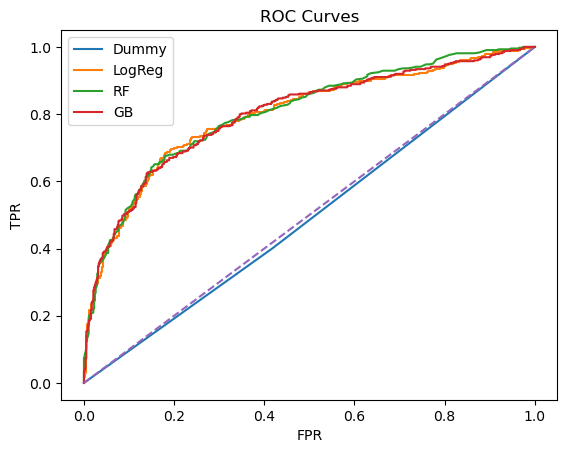

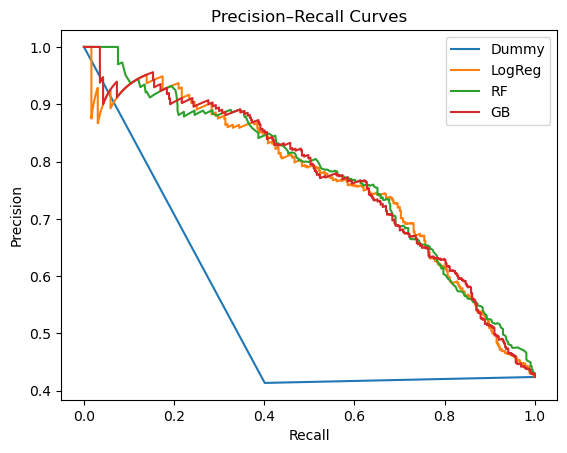

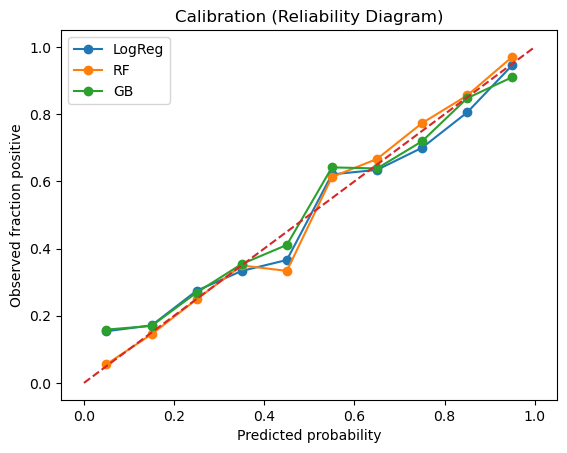

In [12]:

def plot_roc_curves():
    plt.figure()
    for name, p in [("Dummy", p_dum), ("LogReg", p_lr), ("RF", p_rf), ("GB", p_gb)]:
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

def plot_pr_curves():
    plt.figure()
    for name, p in [("Dummy", p_dum), ("LogReg", p_lr), ("RF", p_rf), ("GB", p_gb)]:
        prec, rec, _ = precision_recall_curve(y_test, p)
        plt.plot(rec, prec, label=name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend()
    plt.show()

def plot_calibration():
    bins = np.linspace(0,1,11)
    plt.figure()
    for name, p in [("LogReg", p_lr), ("RF", p_rf), ("GB", p_gb)]:
        idx = np.digitize(p, bins) - 1
        bin_centers = []
        frac_pos = []
        for b in range(len(bins)-1):
            mask = idx==b
            if mask.any():
                bin_centers.append((bins[b]+bins[b+1])/2)
                frac_pos.append(y_test[mask].mean())
        plt.plot(bin_centers, frac_pos, marker="o", label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction positive")
    plt.title("Calibration (Reliability Diagram)")
    plt.legend()
    plt.show()

plot_roc_curves()
plot_pr_curves()
plot_calibration()


## Decision threshold tuning (maximize F1)

LogReg: best F1 at threshold 0.35 → F1=0.710


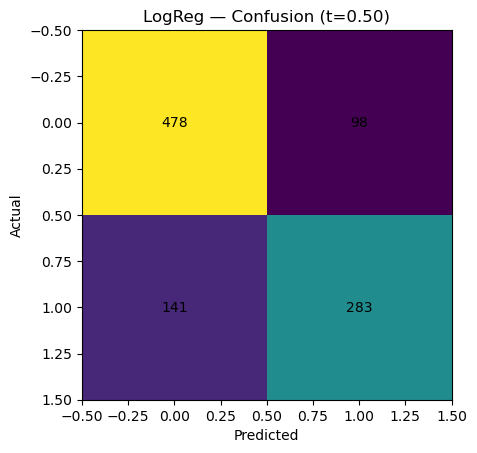

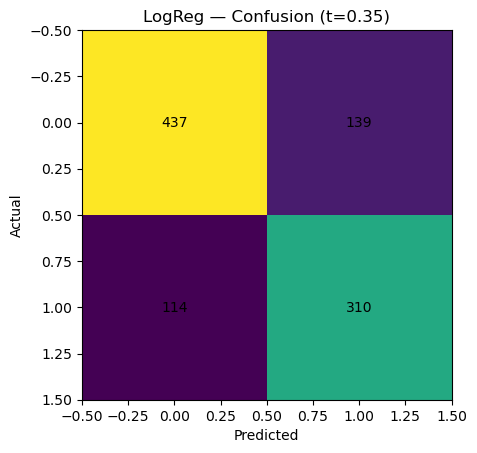

RF: best F1 at threshold 0.44 → F1=0.704


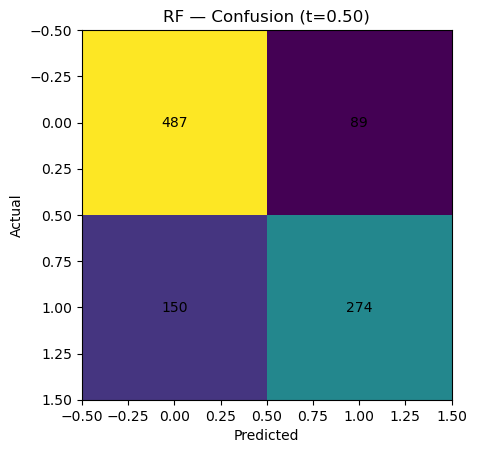

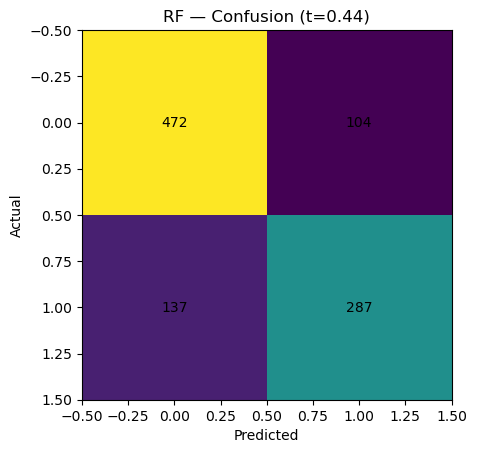

GB: best F1 at threshold 0.29 → F1=0.702


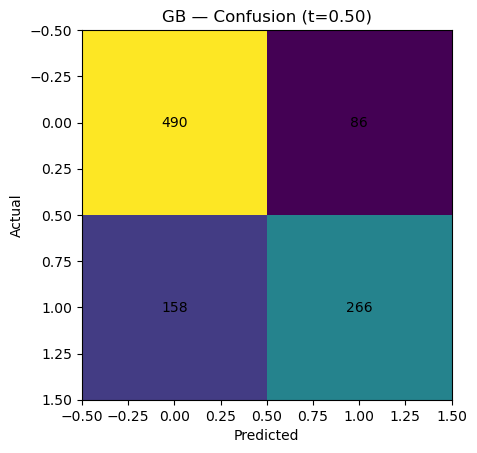

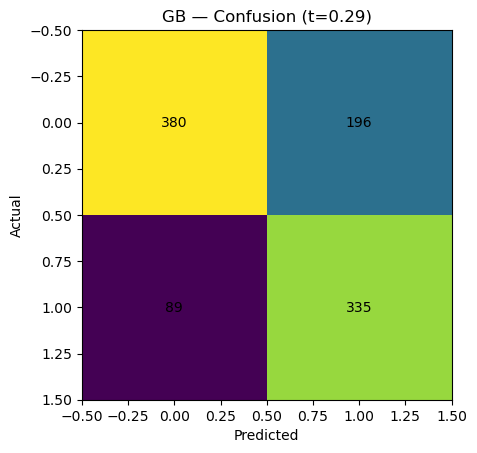

In [13]:

def best_f1_threshold(y_true, y_prob):
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = []
    for t in thresholds:
        f1s.append(f1_score(y_true, (y_prob >= t).astype(int)))
    i = int(np.argmax(f1s))
    return thresholds[i], f1s[i]

def show_confusion(y_true, y_prob, threshold, title="Confusion Matrix"):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.show()
    return cm

for name, p in [("LogReg", p_lr), ("RF", p_rf), ("GB", p_gb)]:
    t_opt, f1_opt = best_f1_threshold(y_test, p)
    print(f"{name}: best F1 at threshold {t_opt:.2f} → F1={f1_opt:.3f}")
    show_confusion(y_test, p, 0.50, title=f"{name} — Confusion (t=0.50)")
    show_confusion(y_test, p, t_opt, title=f"{name} — Confusion (t={t_opt:.2f})")


## Save metrics (tidy format)

In [14]:

holdout = pd.DataFrame(results).T
cv_df = pd.DataFrame(cv_scores).T.rename(columns={"mean":"cv_auc_mean","std":"cv_auc_std"})
cv_df.index.name = "model"
public_metrics = holdout.merge(cv_df, left_index=True, right_index=True, how="left")
metrics_path = "insomnia_ml_metrics_public.csv"
public_metrics.to_csv(metrics_path, index=True)
print("Saved tidy metrics to", metrics_path)
public_metrics.round(4)


Saved tidy metrics to insomnia_ml_metrics_public.csv


,roc_auc,pr_auc,acc,f1,brier,cv_auc_mean,cv_auc_std
Dummy,0.4913,0.4198,0.505,0.4072,0.4950,NaN,NaN
LogisticRegression,0.7978,0.7657,0.761,0.7031,0.1745,0.8057,0.0112
RandomForest,0.8041,0.7722,0.761,0.6963,0.1733,0.8051,0.0145
GradientBoosting,0.7994,0.7701,0.756,0.6856,0.1746,0.8051,0.0143



---
**Attribution & License**  
This notebook and any datasets it generates are **© DBbun LLC**.  
Any **commercial use requires a license** from DBbun LLC. Contact DBbun LLC for details.

